In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
%matplotlib inline
pd.options.mode.chained_assignment = None

**1)** Load the data into a dataframe from `data/balance.csv`. Make a scatter matrix of the variables. Comment on the distribution of your variables and describe the relationships between your numeric feature variables and Balance.

In [2]:
balance = pd.read_csv('data/balance.csv', index_col=0)
balance.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


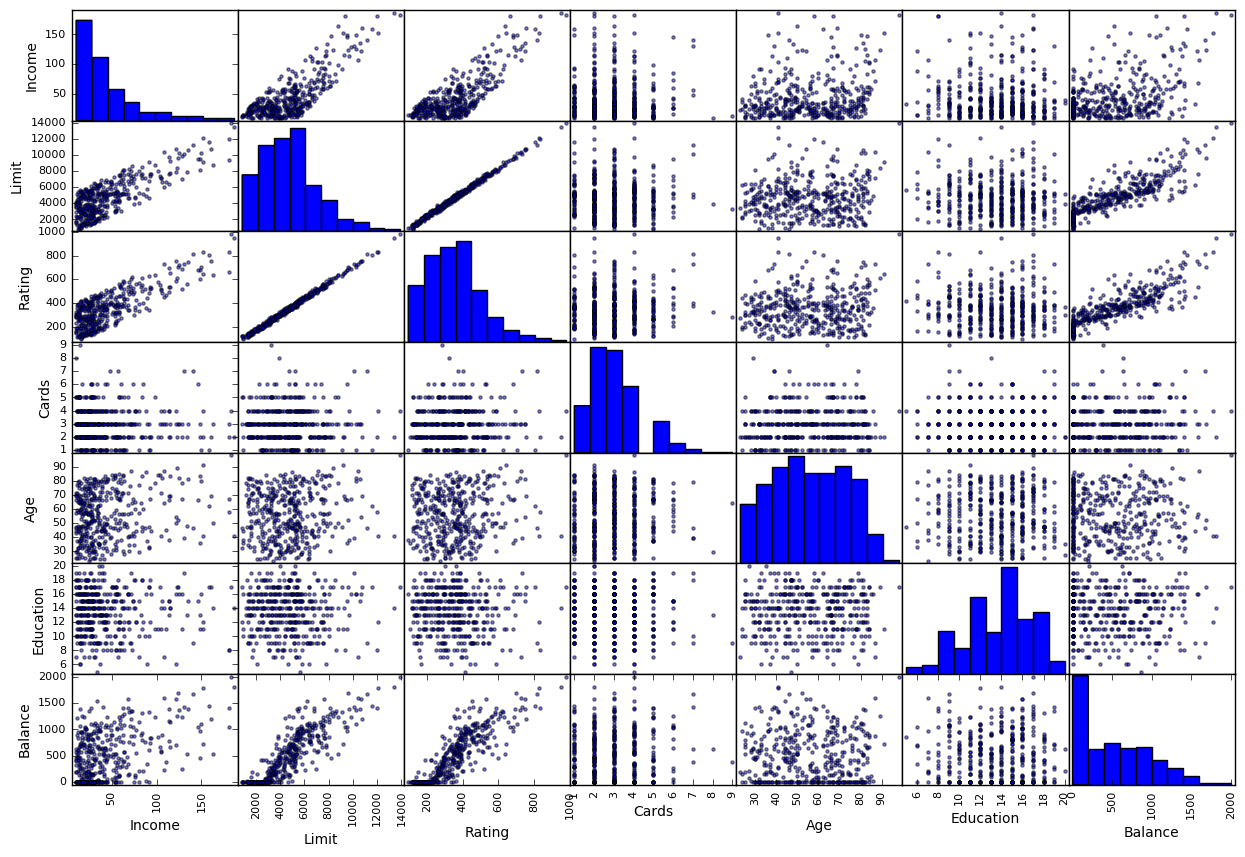

In [3]:
pd.scatter_matrix(balance, figsize=(15, 10))
plt.show()

In [4]:
# Balance is strongly correlated to the Rating and Limit and somewhat related to Income.

**2)** Since Gender and Married are boolean variables, convert the columns to 1/0, i.e. the value should be 1 if the response to Married is Yes, otherwise 0.

In [5]:
# Married - 1, Not Married - 0
balance['Married'] = balance['Married'].map({'Yes': 1, 'No': 0})

# Female - 0, Male - 1
balance['Gender'] = balance['Gender'].map({'Female': 0, ' Male': 1})

# Student Yes - 1, Student No - 0
balance['Student'] = balance['Student'].map({'Yes': 1, 'No': 0})

**3)** Since Ethnicity is a categorical variable that has more than 2 categories, we need to convert the categories within the variable to separate columns with binary responses. These are known as dummy variables. Use get_dummies in pandas to get create dummy variables for Ethnicity. After you create the model, drop the African dummy variable. It can be any dummy variable you want the rest of the dummies to be compared against.

In [6]:
# Get the Dummy variables
ethnicity_dummy = pd.get_dummies(balance['Ethnicity'])
# Only need two of the three values
balance[ ['Asian', 'Caucasian'] ] = ethnicity_dummy[ ['Asian', 'Caucasian'] ]
# Remove the Ethnicity column
del balance['Ethnicity']

**4)** Using all the feature variables, fit a linear regression model to predict Balance. Validate the assumptions required of the linear regression model. Make a residual plot by plotting the fitted y values against the studentized residuals. What do you observe?

In [7]:
def summary_model(X, y, label='scatter'):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    summary = model.summary()
    return summary

def plot_model(X, y, label='Residual Plot'):
    model = sm.OLS(y, X).fit()
    student_resids = model.outlier_test()['student_resid']
    y_hats = model.predict(X)

    plt.scatter(y_hats, student_resids, alpha = .35, label=label)
    plt.legend()
    plt.show()

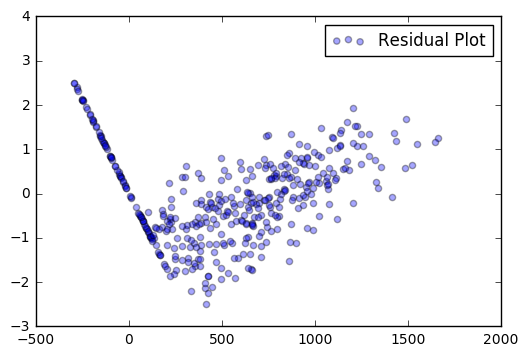

In [8]:
# Separate the Balance from all the other predictors
X = balance.copy()
y = X.pop('Balance')
    
summary_model(X, y)
plot_model(X, y)

**5)** The residuals should resemble a v shape. Try a few other models by excluding some features from the full model. Does the residual plot change?

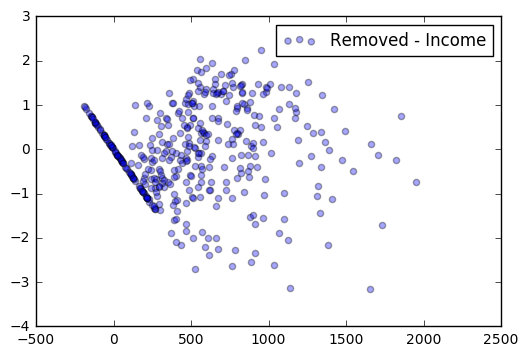

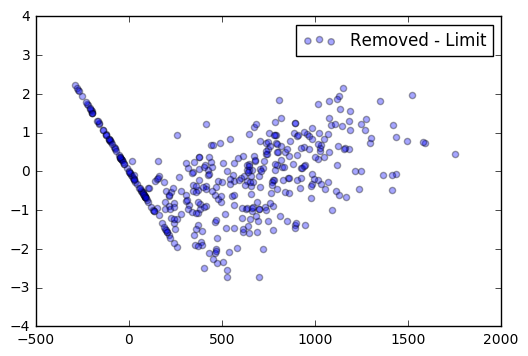

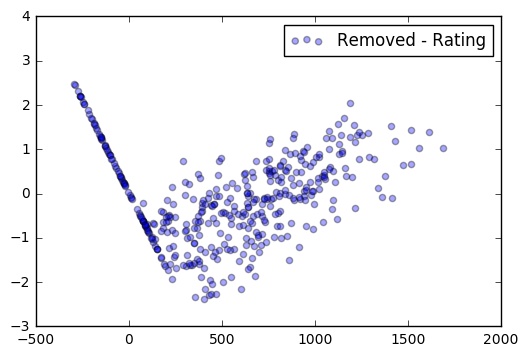

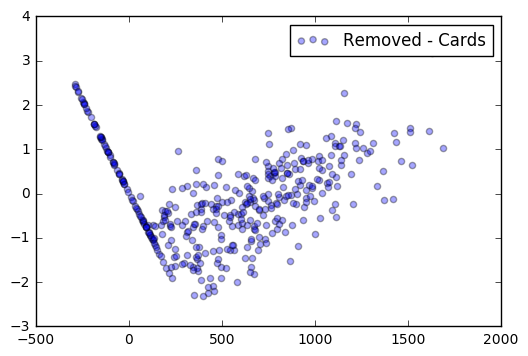

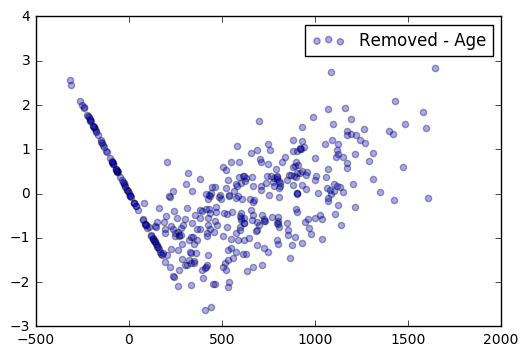

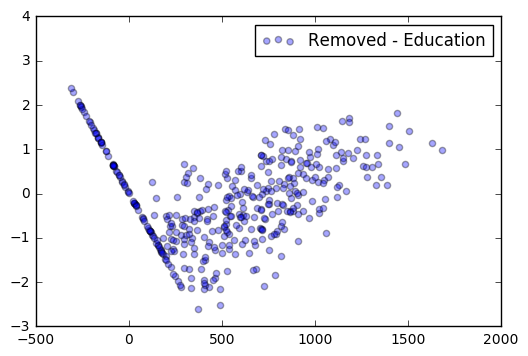

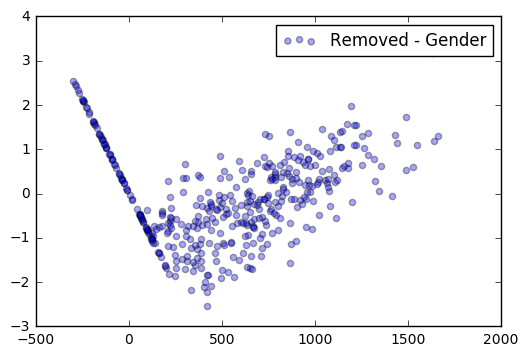

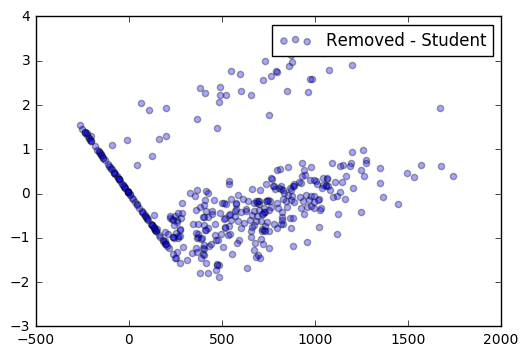

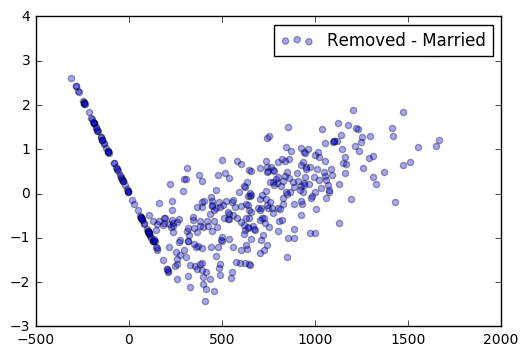

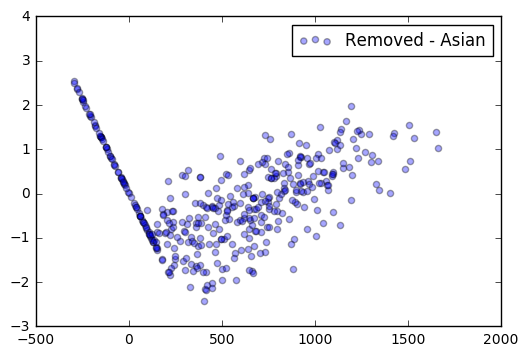

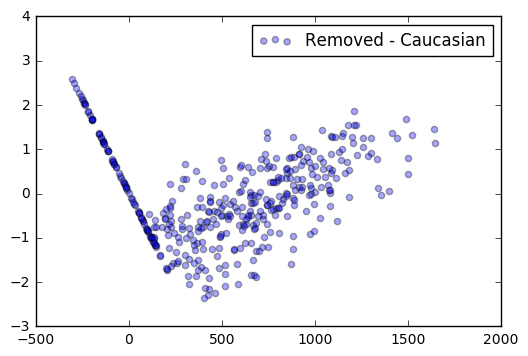

In [9]:
all_columns = X.columns
for col_name in all_columns:
    all_columns_copy = list(all_columns)
    all_columns_copy.remove(col_name)
    plot_model(X[all_columns_copy], y, 'Removed - ' + str(col_name))

You should find that various Balance values are fitted around the 0 point. It would seem that the abundance of obseravtions at 0 balance is affecting how the model is fitted. Plot the histogram for Balance again, except set bins=100. What do you observe?

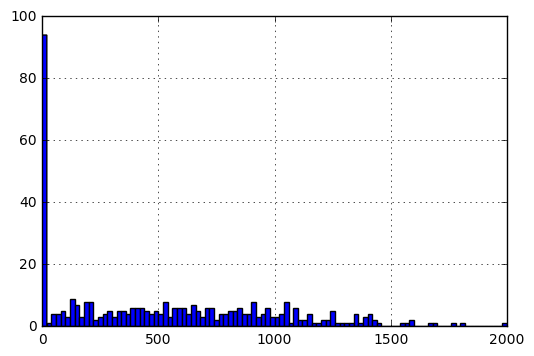

In [10]:
# Plotting the histogram for the Balance (y)
y.hist(bins=100)
plt.show()

**6)** Re-plot the univariate scatter plot on a bigger figure size. Look for variable(s) that can differentiate most zero balance observation from non-zero balance observations. Use the provided pandas code as a reference.

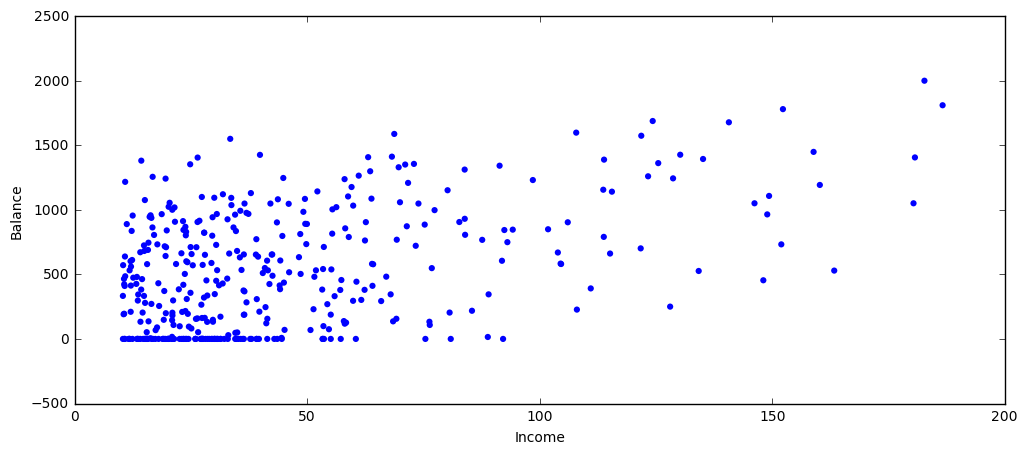

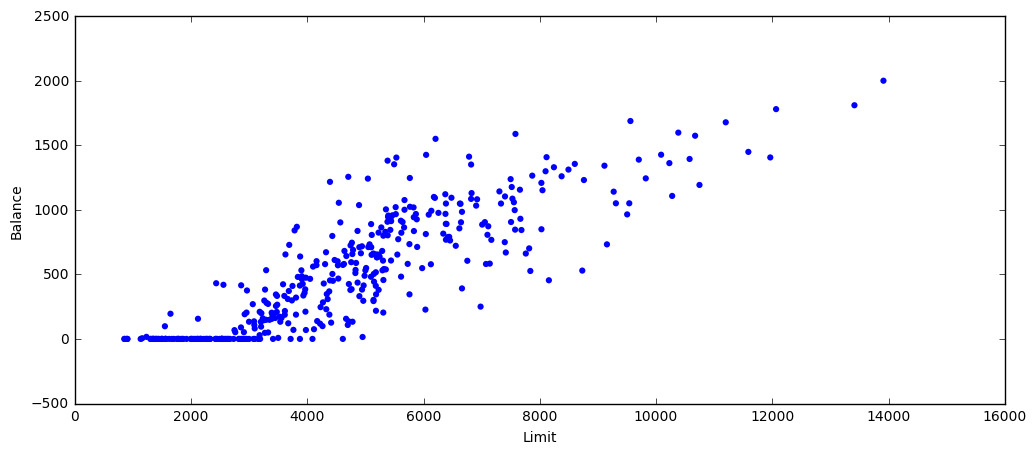

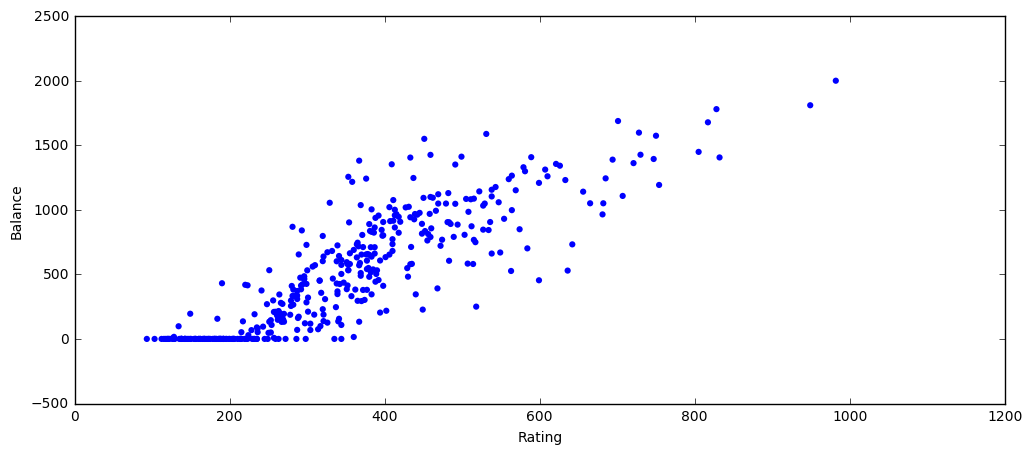

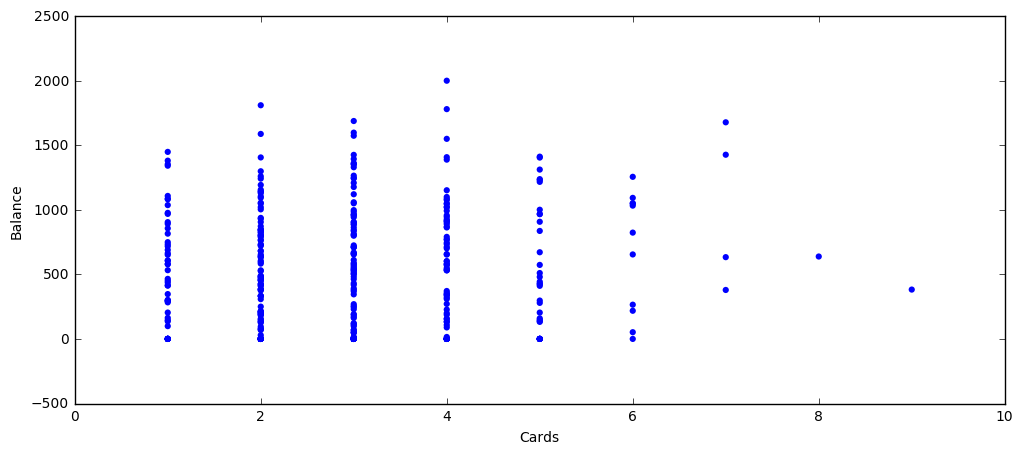

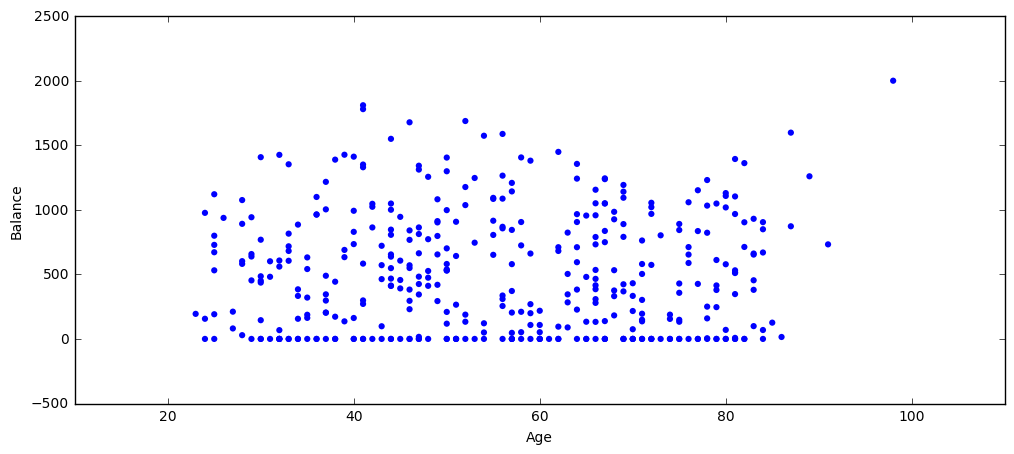

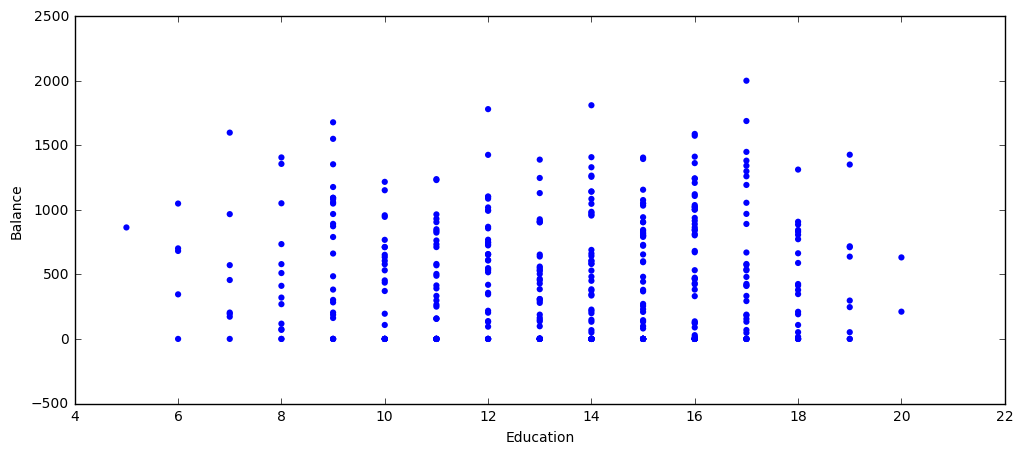

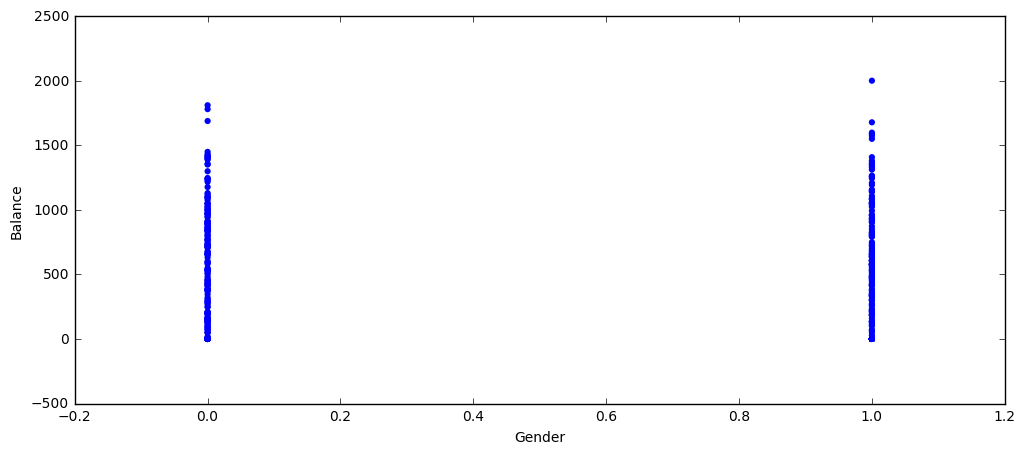

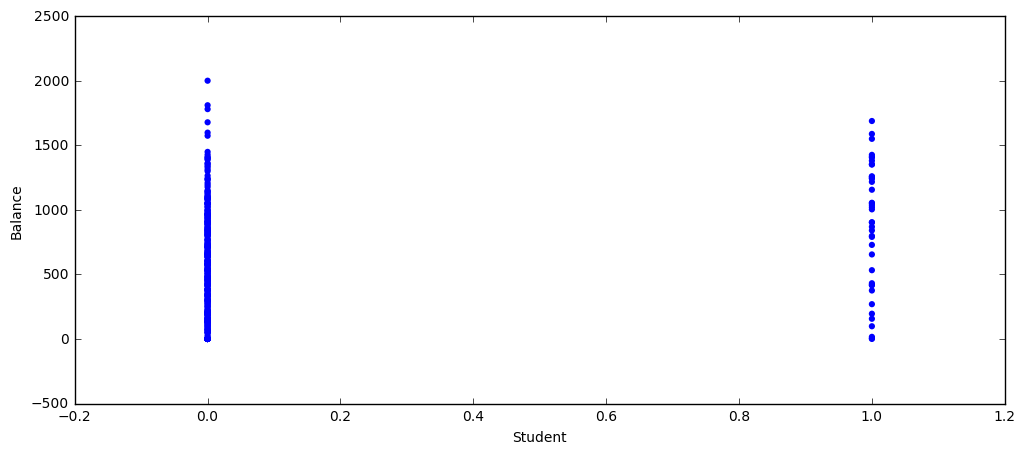

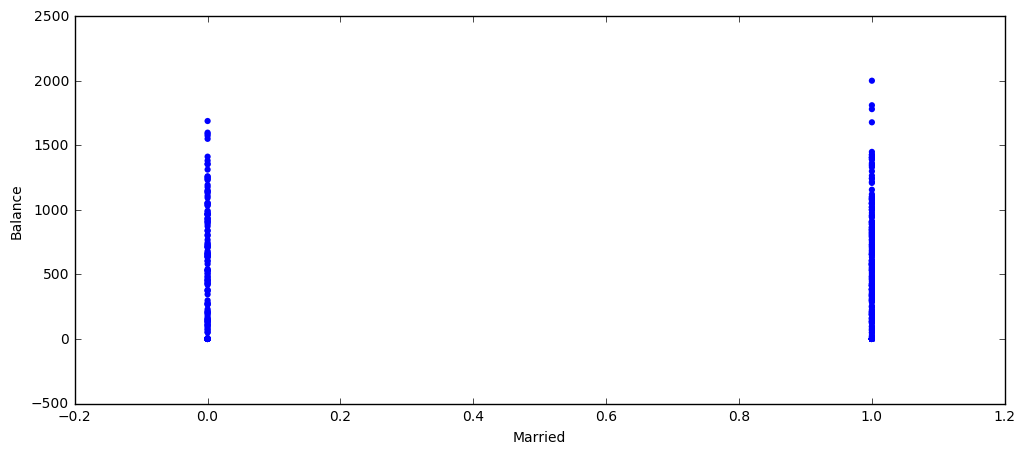

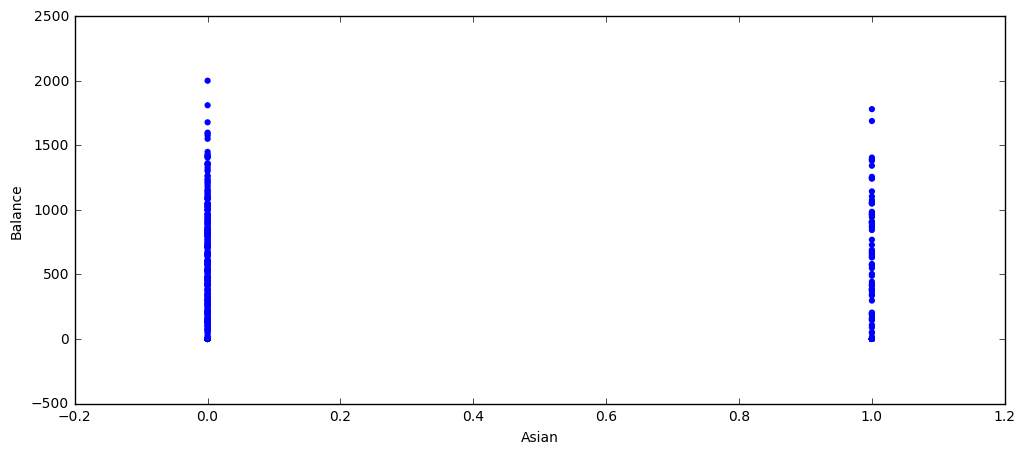

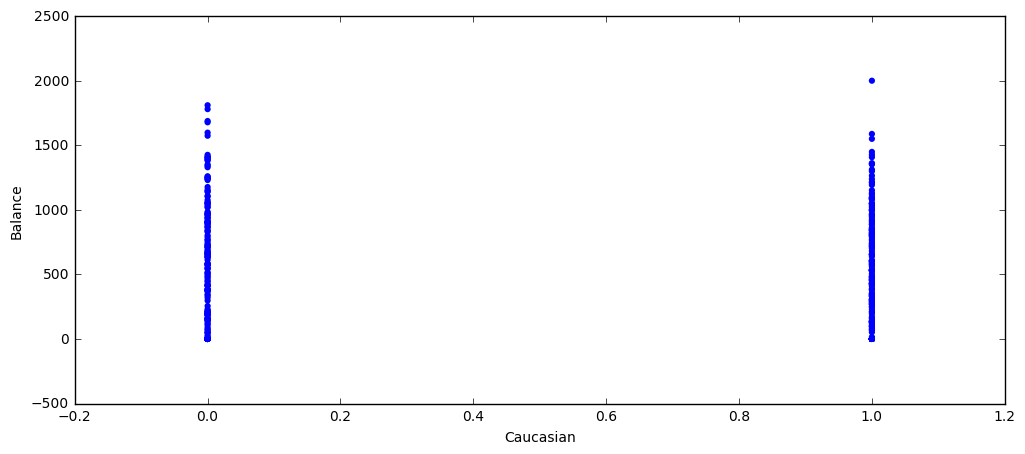

In [11]:
for col in all_columns:
    balance.plot(kind='scatter', y='Balance', x=col, edgecolor='none', figsize=(12, 5))
    plt.xlabel(col)
    plt.ylabel('Balance')
    plt.show()

**7)** Once you find the relevant variable(s), decide on a threshold that would give you reasonable separation between the zero and non-zero obseravations, i.e. minimize false positive and false negative predictions. You can do it visually based on your plot now, but a slightly more sophisticated way to model this would be with a
Decision Tree which we will cover later in the course.

In [12]:
# Removed the data points below the treshold - 3000 Limit
limit_cond = balance['Limit'] >= 3000
new_balance = balance[limit_cond]

**8)** Remove the data points below the decided threshold of your chosen variable and examine the number of zero obseravations that remain.

This is an atypical first step for linear regression but works well in this situation because we have a large loading of 0 observations in our response, which are affecting the regression fit. In essence, we are fitting two models, one feeding into the other. The first model simply predicts 0 or non-zero balance based on a single feature, the second model predicts the balance given that the first model predicted non-zero balance.

In [13]:
# Separated Balance from all the other predictors
X_new = new_balance.copy()
y_new = X_new.pop('Balance')

# Fit a linear regression model to our new X and y
summary_model(X_new, y_new)

# As for everything below 3000 Limit, predict 0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     6081.
Date:                Wed, 05 Jul 2017   Prob (F-statistic):               0.00
Time:                        14:14:30   Log-Likelihood:                -1439.9
No. Observations:                 304   AIC:                             2904.
Df Residuals:                     292   BIC:                             2948.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -663.8842     11.884    -55.862      0.000    -687.274    -640.494
Income        -9.5647      0.075   -127.458      0.000      -9.712      -9.417
Limit          0.3141      0.011     29.559      0.000       0.293       0.335
Rating         0.0473      0.158      0.300      0.764      -0.263       0.358
Cards         25.0709      1.358     18.456      0.000      22.397      27.744
Age           -1.0922      0.096    -11.376      0.000      -1.281      -0.903
Education     -0.0383      0.517     -0.074      0.941      -1.055       0.979
Gender         2.1935      3.245      0.676      0.500      -4.193       8.580
Student      493.8736      5.528     89.347      0.000     482.995     504.753
Married       -3.9065      3.419     -1.142      0.254     -10.636       2.823
Asian          3.7828      4.665      0.811      0.418      -5.398      12.963
Caucasian      0.1146      3.973      0.029      0.977      -7.704       7.934
==============================================================================
Omnibus:                      331.480   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13654.659
Skew:                           4.716   Prob(JB):                         0.00
Kurtosis:                      34.449   Cond. No.                     4.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**9)** Now re-fit the same model and examine the residuals. It might still be skewed, but should resemble more of a normal distribution. While it's important to strive for models that pass the model diagnostic tests, in practice we sometimes loosen the restrictions a bit.

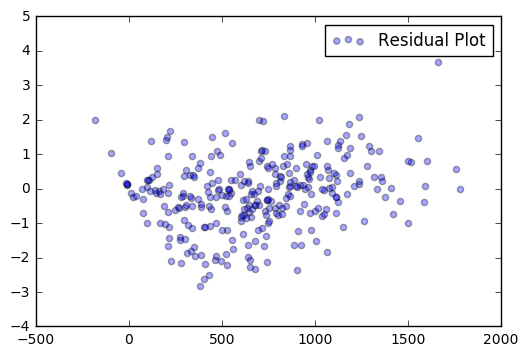

In [14]:
plot_model(X_new, y_new)

**10)** Try out a few different models using different sets of features. This can be a bit of an art, but some guidelines you can use are to (i) exclude features which don't have statistically significant beta coefficients and (ii) exclude features with high variance inflation factor or high collinearity with another feature already in the model.

To decide among the models, you can use adjusted R^2 or F-tests. Tomorrow we'll get into a more general model-evaluation technique called cross-validation.

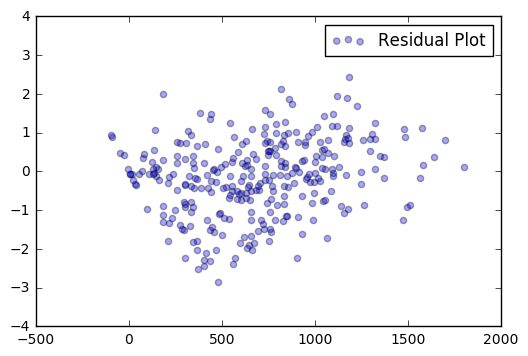

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3602.
Date:                Wed, 05 Jul 2017   Prob (F-statistic):          2.91e-282
Time:                        14:14:31   Log-Likelihood:                -1589.2
No. Observations:                 304   AIC:                             3194.
Df Residuals:                     296   BIC:                             3224.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -579.5257     16.906    -34.279      0.000    -612.797    -546.254
Income        -9.6468      0.122    -79.395      0.000      -9.886      -9.408
Limit          0.3182      0.002    138.639      0.000       0.314       0.323
Age           -0.9911      0.155     -6.377      0.000      -1.297      -0.685
Education     -1.3059      0.827     -1.579      0.115      -2.934       0.322
Student      494.5968      8.859     55.828      0.000     477.162     512.032
Asian          6.9741      7.492      0.931      0.353      -7.771      21.719
Caucasian      0.7491      6.397      0.117      0.907     -11.839      13.338
==============================================================================
Omnibus:                      104.561   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              365.342
Skew:                           1.480   Prob(JB):                     4.64e-80
Kurtosis:                       7.481   Cond. No.                     3.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
chosen_columns = ['Income', 'Limit', 'Age', 'Education', 'Student', 'Asian', 'Caucasian']
X_chosen_cols = X_new[chosen_columns]

plot_model(X_chosen_cols, y_new)
summary_model(X_chosen_cols, y_new)

## Extra Credit

**1)**

In [16]:
X_new_sub = new_balance['Income']
summary = summary_model(X_new_sub, y_new, label='Income')
print summary

X_new_sub = new_balance[['Income', 'Student']]
summary = summary_model(X_new_sub, y_new, 'Income/Student')
print summary


new_balance.loc[:, 'Income*Student'] = new_balance['Income'] * new_balance['Student']
X_new_sub = new_balance[['Income', 'Student', 'Income*Student']]
summary = summary_model(X_new_sub, y_new, 'Income/Student Interaction')
print summary

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     43.55
Date:                Wed, 05 Jul 2017   Prob (F-statistic):           1.85e-10
Time:                        14:14:31   Log-Likelihood:                -2246.1
No. Observations:                 304   AIC:                             4496.
Df Residuals:                     302   BIC:                             4504.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        470.2326     38.301     12.277      0.0

When we added Student to Income, the model's accuracy in terms of Adjusted R^2 went up. The interaction (Income * Student) is also significant, and our model's accuracy in terms of Adjusted R^2 also increases.

**2)**

In [17]:
student_cond = new_balance['Student'] == 1
student_df = new_balance.loc[student_cond, ['Income', 'Balance']]
nonstudent_df = new_balance.loc[~student_cond, ['Income', 'Balance']]

student_income = sm.add_constant(student_df['Income'])
student_balance = student_df['Balance']
model = sm.OLS(student_balance, student_income).fit()
student_y = model.predict(student_income)

nonstudent_income = sm.add_constant(nonstudent_df['Income'])
nonstudent_balance = nonstudent_df['Balance']
model = sm.OLS(nonstudent_balance, nonstudent_income).fit()
nonstudent_y = model.predict(nonstudent_income)

student_income.drop('const', axis=1, inplace=True)
nonstudent_income.drop('const', axis=1, inplace=True)

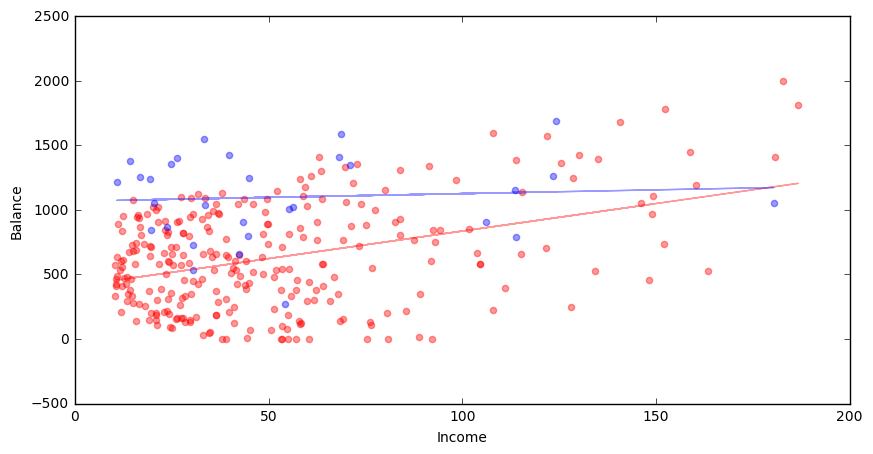

In [18]:
plt.figure(figsize=(10, 5))
# Plot the non-student 
plt.scatter(nonstudent_income, nonstudent_balance,
            color='r', alpha=0.4)
plt.plot(nonstudent_income, nonstudent_y, color='r', alpha=0.4)

# Plot the student
plt.scatter(student_income, student_balance,
            color='b', alpha=0.4)
plt.plot(student_income, student_y, color='b', alpha=0.4)

plt.xlabel('Income', size=10)
plt.ylabel('Balance', size=10)
plt.show()